In [1]:
import numpy as np

import sys

sys.path.append('../scripts')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from elements import *

import measurement as me

In [8]:
import matplotlib.pyplot as plt
%matplotlib notebook

## Define typical optomechanical system

In [5]:
omega_c = 5e9*np.pi*2

kappa_0 = 0.3e6*np.pi*2
kappa_ex = 0.4e6*np.pi*2

omega_m = 5e6*np.pi*2
gamma_m = 100*np.pi*2

P_in = 2e-10

g_0 = 10*np.pi*2

omega_drive = omega_c - 0.5 * omega_m


from DCnonlinearities import optomechanics

omdir = optomechanics(P_in, kappa_0, kappa_ex, omega_c, omega_drive, omega_m, g_0)

g= omdir['g']
omega_c = omdir['omega_c']

a = Mode('a', omega_c)
b = Mode('b', omega_m)

a_inex = Input('ex', a, kappa_ex, kind = 'drive', omega_drive = omega_drive, bath_temp=10e-3)
a_in0 = Input('0', a, kappa_0, kind = 'bath', bath_temp=10e-3)

b_in0 = Input('0', b, gamma_m, kind = 'bath', bath_temp=10e-3)

g_ab = Coupling(a, b, g * np.array([1,1]))

sys_om = System([a, b], [b_in0 ,a_in0, a_inex], [g_ab])

## Measure mechanical sidebands

In [6]:
a_outex = Output(sys_om, a_inex)

omegas = np.linspace(omega_drive - 1.5*omega_m, omega_drive + 1.5*omega_m, 1000)

spec = np.array([me.spectrum(a_outex,omega, components=True) for omega in omegas])


<IPython.core.display.Javascript object>


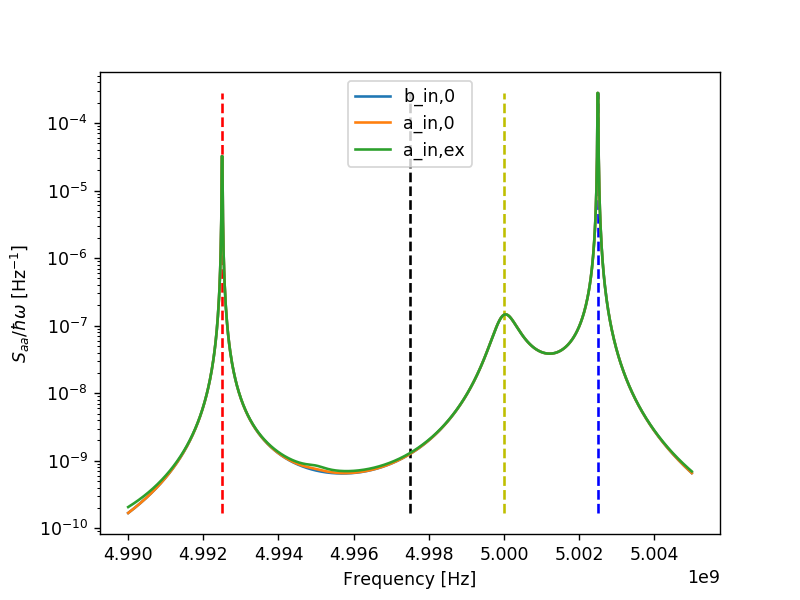

In [9]:
plt.figure()

for i, inp in enumerate(sys_om.inputs):
    plt.semilogy(omegas/2/np.pi, spec[:,i], label = str(inp))
plt.vlines(np.array([omega_drive - omega_m, omega_drive, omega_drive + omega_m, omega_c])/2/np.pi,  np.min(spec), np.max(spec),colors=['r','black', 'b', 'y'], linestyles='--')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{aa}/\hbar \omega$ [Hz$^{-1}$]')
plt.legend();

In [ ]:
#test